In [1]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from matplotlib import pyplot
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [2]:
# SET PATH
path = f"{os.getcwd()}/dataset/train.parquet"
# LOAD PARQUET DATASET WITH FEATURE ENGINEERING
df = pd.read_parquet(path=path)

In [3]:
# REDUCE DTYPE FOR CUSTOMER AND DATE
df['customer_ID']= df['customer_ID'].str[-16:].apply(int, base=16)

# S_2 is not relevant so lets drop it
df.drop(['S_2'],axis=1,inplace=True)

# df = df.fillna(-127)

# There are multiple transactions. Let's take only the latest transaction from each customer.
df= df.groupby('customer_ID').tail(1)
df= df.set_index(['customer_ID'])

print('shape of data:', df.shape)

shape of data: (458913, 188)


In [4]:
df.head()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
customer_ID,,,,,,,,,,,,,,,,,,,,,
13914591055249847850,0.934745,0,0.009382,1.007647,0.006104,0.135021,0.0,0.007174,NaN,NaN,...,-1,-1,-1,0,0,0.0,NaN,0,0.002970,0
11750091188498716901,0.880519,6,0.034684,1.004028,0.006911,0.165509,0.0,0.005068,NaN,0.060646,...,-1,-1,-1,0,0,0.0,NaN,0,0.003169,0
7128959966677571777,0.880875,0,0.004284,0.812649,0.006450,NaN,0.0,0.007196,NaN,NaN,...,-1,-1,-1,0,0,0.0,NaN,0,0.000834,0
6537921148391624412,0.621776,0,0.012564,1.006183,0.007829,0.287766,0.0,0.009937,NaN,0.046104,...,-1,-1,-1,0,0,0.0,NaN,0,0.005560,0
2065103583825424365,0.871900,0,0.007679,0.815746,0.001247,NaN,0.0,0.005528,NaN,0.044671,...,-1,-1,-1,0,0,0.0,NaN,0,0.006944,0


In [5]:
# Read and process Train Labels
targets = pd.read_csv(f"{os.getcwd()}/dataset/train_labels.csv")
targets['customer_ID'] = targets['customer_ID'].str[-16:].apply(int, base=16)
targets = targets.set_index('customer_ID')
train_data = df.merge(targets, left_index=True, right_index=True, how='left')
train_data.target = train_data.target.astype('int8')
del targets, df
# NEEDED TO MAKE CV DETERMINISTIC (Pandas merge above randomly shuffles rows)
train_data = train_data.sort_index().reset_index()

# FEATURES
FEATURES = train_data.columns[1:-1]
print(f'There are {len(FEATURES)} features!')
print("Train data Shape", train_data.shape)

There are 188 features!
Train data Shape (458913, 190)


In [6]:
x_train = train_data.drop(['target','customer_ID'],axis=1).values
y_train = train_data['target'].values

In [7]:
# INITIALIZED XGBOOST MODEL
xgb_cal = xgb.XGBClassifier()

In [8]:
# Calculating CV Score
kfold = 5
skf = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=0)
lst_accu_stratified_test = []
lst_accu_stratified_train = []
for i, (train_index, test_index) in enumerate(skf.split(x_train, y_train), start=1):
    print('[Fold %d/%d]' % (i, kfold))
    x_train_split, x_test_split  = x_train[train_index], x_train[test_index]
    y_train_split, y_test_split  = y_train[train_index], y_train[test_index]
    xgb_cal.fit(x_train_split, y_train_split)
    y_predict_test = xgb_cal.predict(x_test_split)
    lst_accu_stratified_test.append(accuracy_score(y_test_split, y_predict_test))
    y_predict_train = xgb_cal.predict(x_train_split)
    lst_accu_stratified_train.append(accuracy_score(y_train_split,y_predict_train))

[Fold 1/5]
[Fold 2/5]
[Fold 3/5]
[Fold 4/5]
[Fold 5/5]


In [9]:
print(lst_accu_stratified_test)
print(lst_accu_stratified_train)

# Calculating Accuracy
print("Average Accuracy Score on test set:", np.mean(lst_accu_stratified_test))
print("Average Accuracy Score on train set:", np.mean(lst_accu_stratified_train))

[0.8992623906387893, 0.8990553806260418, 0.8981292832005927, 0.9004162036129089, 0.8994465145671264]
[0.9192220739247678, 0.9185247732410863, 0.9192247977555634, 0.917443637284784, 0.9186775292742917]
Average Accuracy Score on test set: 0.8992619545290917
Average Accuracy Score on train set: 0.9186185622960987


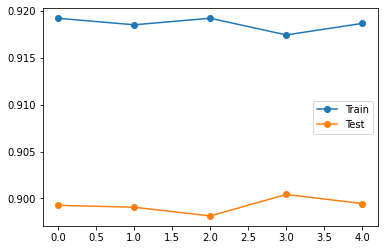

In [10]:
# plot of train and test scores
values = [i for i in range(kfold)]
pyplot.plot(values, lst_accu_stratified_train, '-o', label='Train')
pyplot.plot(values, lst_accu_stratified_test, '-o', label='Test')
pyplot.legend()
pyplot.show()